Installing Pyspark

SENTIMENTAL ANALYSIS OF SOCIAL MEDIA DATA

In [ ]:
!pip install pyspark


Uploaded Tweets.csv file from kaggale.

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Tweets.csv to Tweets.csv


Read Dataset with PySpark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *

# Start Spark session
spark = SparkSession.builder.appName("TwitterSentiment").getOrCreate()

# Path to uploaded dataset
path = "/content/Tweets.csv"

# If dataset has headers (e.g., Airline Sentiment dataset)
df = spark.read.csv(path, header=True, inferSchema=True, multiLine=True, escape="\"", quote="\"")

print("Row count:", df.count())
df.show(5, truncate=80)



Row count: 14640
+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------------------+----------+-------------------+-------------+--------------------------------------------------------------------------------+-----------+-------------------+--------------+--------------------------+
|          tweet_id|airline_sentiment|airline_sentiment_confidence|negativereason|negativereason_confidence|       airline|airline_sentiment_gold|      name|negativereason_gold|retweet_count|                                                                            text|tweet_coord|      tweet_created|tweet_location|             user_timezone|
+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------------------+----------+-------------------+-------------+--------------------------------------------------------------------------------+-----------+-----

Raw tweets contain URLs, mentions, hashtags, special characters, which will confuse sentiment analysis. So we’ll normalize them.

In [ ]:
import re
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType

# Define a cleaning function
def clean_tweet(text):
    if text is None:
        return ""
    # lowercase
    text = text.lower()
    # remove urls
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # remove @mentions
    text = re.sub(r'@\w+', '', text)
    # remove hashtags (# only, keep word)
    text = re.sub(r'#', '', text)
    # remove punctuation/numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Register as UDF
clean_tweet_udf = udf(lambda x: clean_tweet(x), StringType())

# Apply cleaning on the text column (adjust column name if different in your dataset)
df_clean = df.withColumn("clean_text", clean_tweet_udf(col("text")))

# Show before and after
df_clean.select("text", "clean_text").show(10, truncate=80)


+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|                                                                            text|                                                                      clean_text|
+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|                                             @VirginAmerica What @dhepburn said.|                                                                       what said|
|        @VirginAmerica plus you've added commercials to the experience... tacky.|                            plus youve added commercials to the experience tacky|
|         @VirginAmerica I didn't today... Must mean I need to take another trip!|                             i didnt today must mean i need to take another trip|
|@VirginAmerica 

Now removing Stopwords with Spark ML
Now your tweets are normalized and tokenized, ready for sentiment classification.

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover

# Tokenize
tokenizer = Tokenizer(inputCol="clean_text", outputCol="words")
df_tokens = tokenizer.transform(df_clean)

# Remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df_final = remover.transform(df_tokens)

df_final.select("clean_text", "filtered_words").show(10, truncate=80)


+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|                                                                      clean_text|                                                                  filtered_words|
+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|                                                                       what said|                                                                          [said]|
|                            plus youve added commercials to the experience tacky|                            [plus, youve, added, commercials, experience, tacky]|
|                             i didnt today must mean i need to take another trip|                           [didnt, today, must, mean, need, take, another, trip]|
|its really aggr

Sentimental Analysis

In [ ]:
from pyspark.sql import functions as F

# Explode words before grouping
df_words = df_final.select("airline_sentiment", F.explode("filtered_words").alias("word"))

# Remove empty tokens (optional)
df_words = df_words.filter(F.length("word") > 2)

# Count words per sentiment
df_top_words = (
    df_words.groupBy("airline_sentiment", "word")
    .count()
    .orderBy("count", ascending=False)
)

df_top_words.show(20, truncate=80)



+-----------------+---------+-----+
|airline_sentiment|     word|count|
+-----------------+---------+-----+
|         negative|   flight| 2918|
|         negative|      get|  984|
|         negative|cancelled|  920|
|         negative|  service|  742|
|         negative|    hours|  653|
|         negative|     help|  610|
|         positive|   thanks|  609|
|         negative|     hold|  608|
|         negative| customer|  604|
|          neutral|   flight|  602|
|         negative|     time|  584|
|         negative|    plane|  517|
|         negative|  delayed|  493|
|         negative|     cant|  486|
|         negative|    still|  480|
|         negative|      amp|  475|
|         positive|    thank|  453|
|         negative|     call|  448|
|         negative|     hour|  444|
|         negative|flightled|  442|
+-----------------+---------+-----+
only showing top 20 rows



After cleaning tweets + sentiment, extracted hashtags, time trends, and run more insights.

In [ ]:
from pyspark.sql import functions as F

# Extract hashtags (words starting with #)
df_hashtags = df_clean.select(
    "airline_sentiment",
    F.explode(
        F.expr("filter(split(clean_text, ' '), x -> x like '#%')")
    ).alias("hashtag")
)

# Remove '#' symbol and lowercase
df_hashtags = df_hashtags.withColumn("hashtag", F.lower(F.regexp_replace("hashtag", "#", "")))

# Count top hashtags per sentiment
df_top_hashtags = (
    df_hashtags.groupBy("airline_sentiment", "hashtag")
    .count()
    .orderBy(F.col("count").desc())
)

df_top_hashtags.show(20, truncate=80)



+-----------------+-------+-----+
|airline_sentiment|hashtag|count|
+-----------------+-------+-----+
+-----------------+-------+-----+



grouped the dataset by day to see trends

In [ ]:
# Convert timestamp to date
df_time = df.withColumn("date", F.to_date("tweet_created", "EEE MMM dd HH:mm:ss z yyyy"))

# Group by date and sentiment
df_trend = (
    df_time.groupBy("date", "airline_sentiment")
    .count()
    .orderBy("date")
)

df_trend.show(20, truncate=80)


+----------+-----------------+-----+
|      date|airline_sentiment|count|
+----------+-----------------+-----+
|2015-02-17|          neutral|  220|
|2015-02-17|         negative|  552|
|2015-02-17|         positive|  181|
|2015-02-18|         positive|  285|
|2015-02-18|          neutral|  304|
|2015-02-18|         negative|  827|
|2015-02-19|         positive|  286|
|2015-02-19|          neutral|  346|
|2015-02-19|         negative|  666|
|2015-02-20|         negative|  849|
|2015-02-20|          neutral|  383|
|2015-02-20|         positive|  280|
|2015-02-21|         positive|  245|
|2015-02-21|         negative|  901|
|2015-02-21|          neutral|  272|
|2015-02-22|         positive|  281|
|2015-02-22|         negative| 1744|
|2015-02-22|          neutral|  367|
|2015-02-23|          neutral|  711|
|2015-02-23|         negative| 2346|
+----------+-----------------+-----+
only showing top 20 rows



Visualizing group by day to see trends

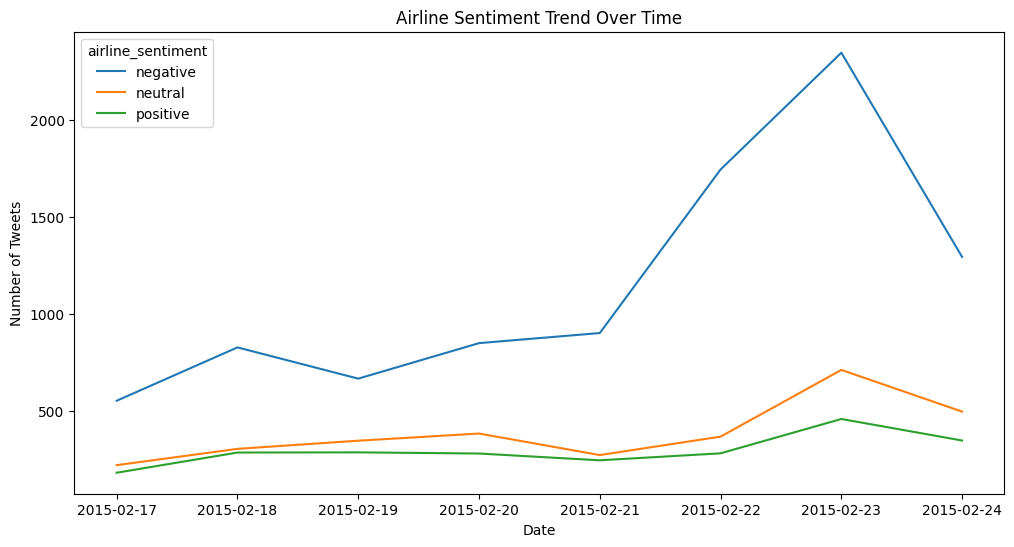

In [ ]:
import matplotlib.pyplot as plt

# Collect small aggregated results into Pandas
pandas_trend = df_trend.toPandas()

# Pivot for plotting
pivot = pandas_trend.pivot(index="date", columns="airline_sentiment", values="count").fillna(0)

pivot.plot(kind="line", figsize=(12,6))
plt.title("Airline Sentiment Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.show()


Since dataset includes an airline column, you can analyze which airline has the most positive vs negative sentiment.

In [ ]:
df.groupBy("airline", "airline_sentiment").count().orderBy("airline", "count", ascending=False).show()


+--------------+-----------------+-----+
|       airline|airline_sentiment|count|
+--------------+-----------------+-----+
|Virgin America|         negative|  181|
|Virgin America|          neutral|  171|
|Virgin America|         positive|  152|
|        United|         negative| 2633|
|        United|          neutral|  697|
|        United|         positive|  492|
|    US Airways|         negative| 2263|
|    US Airways|          neutral|  381|
|    US Airways|         positive|  269|
|     Southwest|         negative| 1186|
|     Southwest|          neutral|  664|
|     Southwest|         positive|  570|
|         Delta|         negative|  955|
|         Delta|          neutral|  723|
|         Delta|         positive|  544|
|      American|         negative| 1960|
|      American|          neutral|  463|
|      American|         positive|  336|
+--------------+-----------------+-----+



Sentiment Distribution

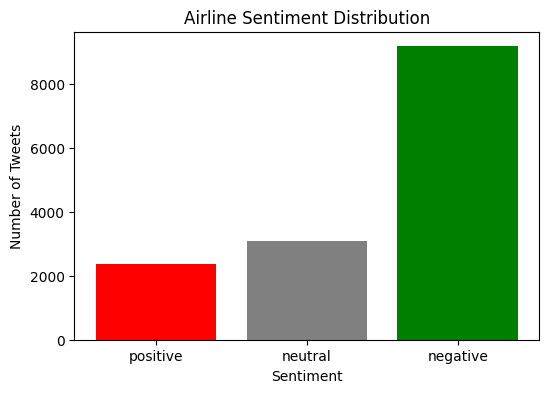

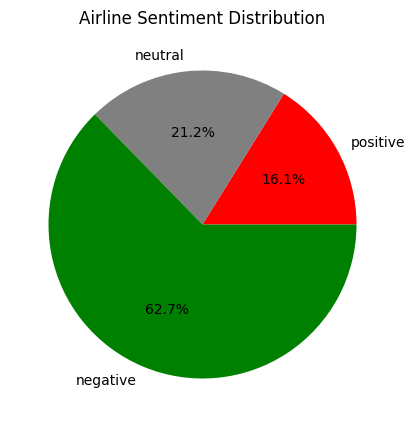

In [ ]:
import matplotlib.pyplot as plt

# Convert to Pandas
pandas_sentiment = df.groupBy("airline_sentiment").count().toPandas()

# Bar chart
plt.figure(figsize=(6,4))
plt.bar(pandas_sentiment["airline_sentiment"], pandas_sentiment["count"], color=["red","gray","green"])
plt.title("Airline Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.show()

# Pie chart
plt.figure(figsize=(5,5))
plt.pie(pandas_sentiment["count"], labels=pandas_sentiment["airline_sentiment"], autopct="%1.1f%%", colors=["red","gray","green"])
plt.title("Airline Sentiment Distribution")
plt.show()


Trend Over Time

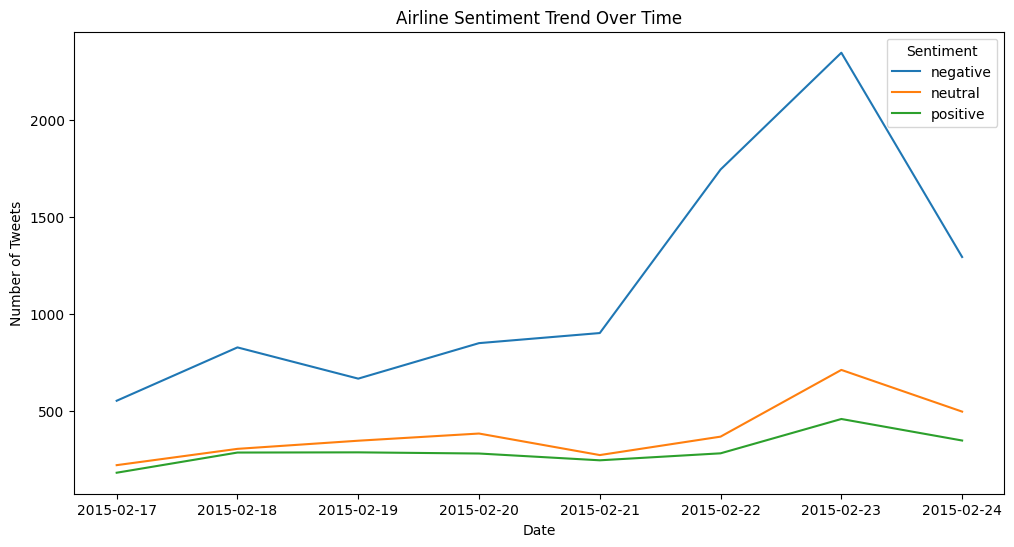

In [ ]:
# Using df_trend from Step 4B
pandas_trend = df_trend.toPandas()
pivot = pandas_trend.pivot(index="date", columns="airline_sentiment", values="count").fillna(0)

pivot.plot(kind="line", figsize=(12,6))
plt.title("Airline Sentiment Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.legend(title="Sentiment")
plt.show()


Airline-wise Sentiment

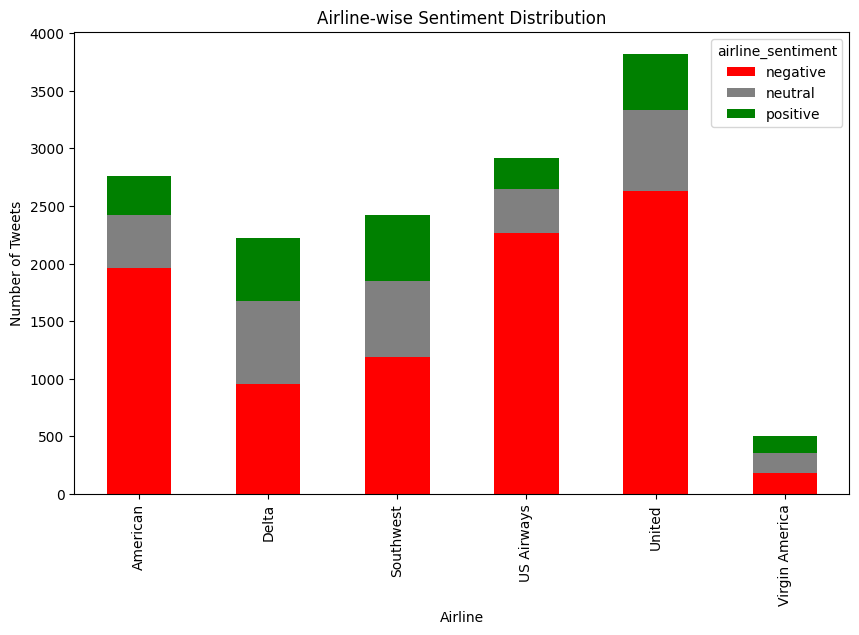

In [ ]:
pandas_airline = df.groupBy("airline","airline_sentiment").count().toPandas()
pivot_airline = pandas_airline.pivot(index="airline", columns="airline_sentiment", values="count").fillna(0)

pivot_airline.plot(kind="bar", stacked=True, figsize=(10,6), color=["red","gray","green"])
plt.title("Airline-wise Sentiment Distribution")
plt.xlabel("Airline")
plt.ylabel("Number of Tweets")
plt.show()



show top words from positive and negative tweets.

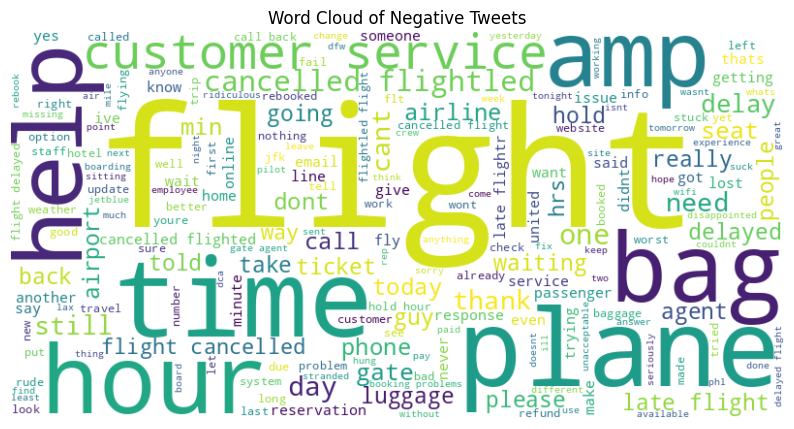

In [ ]:
!pip install wordcloud
from wordcloud import WordCloud

# Collect top words (negative sentiment example)
neg_words = df_words.filter(df_words.airline_sentiment=="negative").toPandas()

text = " ".join(neg_words["word"].tolist())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Negative Tweets")
plt.show()


Extend analysis to larger datasets (e.g., Sentiment140 with 1.6M tweets).

Incorporate real-time streaming using Kafka and Spark Streaming.

Apply machine learning models for advanced sentiment classification.

Explore multilingual sentiment analysis for broader coverage.